In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#importing the essential libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import itertools
################
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import *
%matplotlib inline
from tensorflow import keras
from keras import *
import keras
import cv2
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
# TRAIN :
path1='/content/drive/MyDrive/kaggledata/Raw_colon/train/0_normal'
path2='/content/drive/MyDrive/kaggledata/Raw_colon/train/1_ulcerative_colitis'
path3='/content/drive/MyDrive/kaggledata/Raw_colon/train/2_polyps'
path4='/content/drive/MyDrive/kaggledata/Raw_colon/train/3_esophagitis'
files1=os.listdir(path1)
files2=os.listdir(path2)
files3=os.listdir(path3)
files4=os.listdir(path4)
num_files1=len(files1)
num_files2=len(files2)
num_files3=len(files3)
num_files4=len(files4)
print('0_normal :  ',num_files1)
print('1_ulcerative_colitis :  ',num_files2)
print('2_polyps :  ',num_files3)
print('3_esophagitis :  ',num_files4)

0_normal :   800
1_ulcerative_colitis :   800
2_polyps :   800
3_esophagitis :   800


In [4]:
train_set='/content/drive/MyDrive/kaggledata/Raw_colon/train'
val_set='/content/drive/MyDrive/kaggledata/Raw_colon/val'
test_set='/content/drive/MyDrive/kaggledata/Raw_colon/test'

In [5]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [6]:
# image addressing
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=False,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=False,
    class_mode = 'categorical')

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'0_normal': 0, '1_ulcerative_colitis': 1, '2_polyps': 2, '3_esophagitis': 3}

#Model1 : EfficientNetB2

In [7]:
from tensorflow.keras import regularizers
from keras.regularizers import l2

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False

# Add custom layers
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.35))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 1408)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 batch_normalization (Batch  (None, 256)               10

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [9]:
checkpoint = ModelCheckpoint("model.best.h5",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=30, #steps_per_epoch= training_images/batch_size= 3200/16<=200
    epochs = 50,
    validation_data = validation_generator,
    callbacks=callbacks2,
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7708 - precision: 0.7973 - recall: 0.7458 - auc: 0.9412 
Epoch 1: val_accuracy improved from -inf to 0.85450, saving model to model.best.h5
30/30 [==============================] - 2135s 72s/step - loss: 0.6615 - accuracy: 0.7708 - precision: 0.7973 - recall: 0.7458 - auc: 0.9412 - val_loss: 0.3882 - val_accuracy: 0.8545 - val_precision: 0.8958 - val_recall: 0.8170 - val_auc: 0.9765 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.9062 - precision: 0.9133 - recall: 0.9000 - auc: 0.9835
Epoch 2: val_accuracy improved from 0.85450 to 0.90550, saving model to model.best.h5
30/30 [==============================] - 321s 11s/step - loss: 0.3056 - accuracy: 0.9062 - precision: 0.9133 - recall: 0.9000 - auc: 0.9835 - val_loss: 0.2751 - val_accuracy: 0.9055 - val_precision: 0.9254 - val_recall: 0.8870 - val_auc: 0.9882 - lr: 0.0010
Epoch 3/50
30/30 [=====

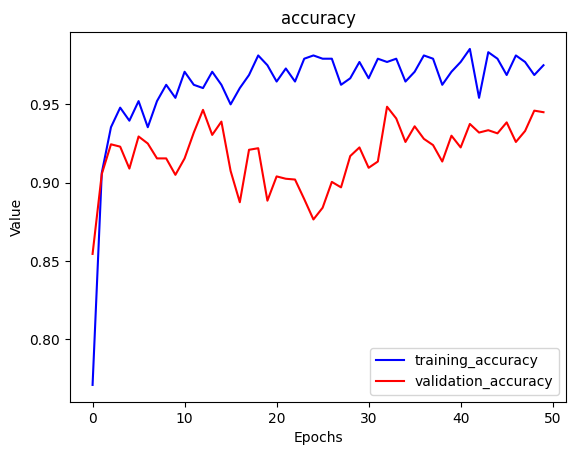

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(acc, color='blue', label="training_accuracy")
plt.plot(val_acc, color='red', label="validation_accuracy")

plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# !cp model.best.h5  /content/drive/MyDrive/kaggledata/Models

In [ ]:
# model0001=load_model('/content/drive/MyDrive/kaggledata/Models/model.best.h5')

In [ ]:
model.load_weights('model.best.h5')
model.evaluate(test_generator)
#بار1:loss: 0.1250 - accuracy: 0.9438 - precision: 0.9485 - recall: 0.9438 - auc: 0.9972
#بار2:loss: 0.0956 - accuracy: 0.9638 - precision: 0.9685 - recall: 0.9613 - auc: 0.9983
#بار3:loss: 0.1332 - accuracy: 0.9475 - precision: 0.9511 - recall: 0.9475 - auc: 0.9961
#acc_avg: 0.9517

50/50 [==============================] - 19s 377ms/step - loss: 0.1332 - accuracy: 0.9475 - precision: 0.9511 - recall: 0.9475 - auc: 0.9961


[0.1332390308380127,
 0.9474999904632568,
 0.9510664939880371,
 0.9474999904632568,
 0.9961163997650146]

#Confusion matrix, F1, recall, precision

In [ ]:
model.load_weights('model.best.h5')
Y_pred = np.argmax(model.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

<ipython-input-85-234530fde308>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model.predict_generator(test_generator), axis=1)


Confusion Matrix : 
 [[200   0   0   0]
 [  2 177  18   3]
 [  4  12 184   0]
 [  0   0   1 199]]


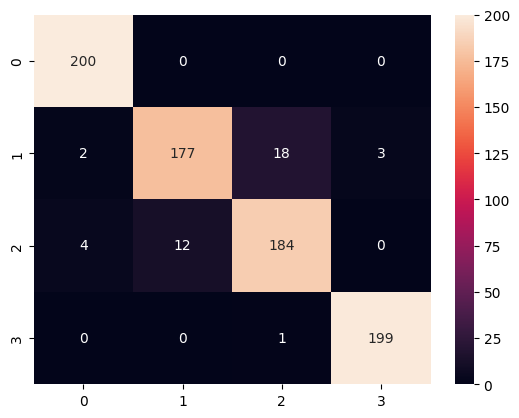

In [ ]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

In [ ]:
model.load_weights('model.best.h5')
X_test= test_generator
y_pred = np.argmax(model.predict_generator(test_generator), axis=1)
y_test = test_generator.classes

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

<ipython-input-87-bf0b29f16f3a>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.argmax(model.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9561027462090863
Precision for all classes: 0.9563496514625227
Recall for all classes: 0.95625


#Performance Plots

Learning curve

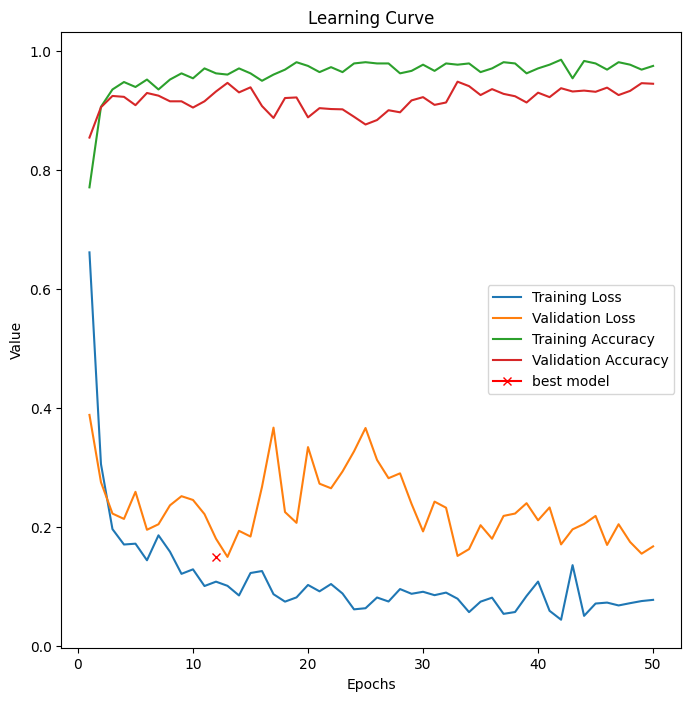

In [17]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# learning curve:
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

Precision plot

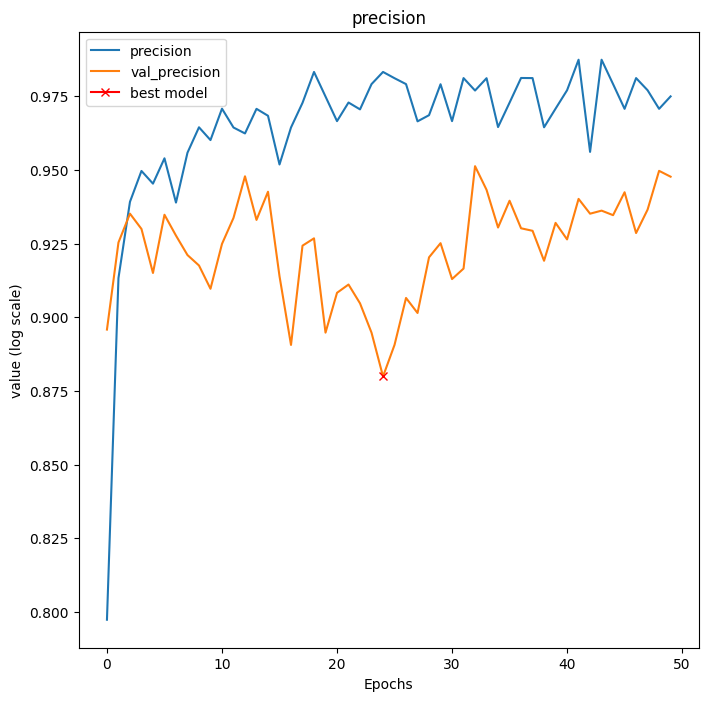

In [18]:
plt.figure(figsize=(8, 8))
plt.title("precision")
plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["val_precision"], label="val_precision")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

Recall plot

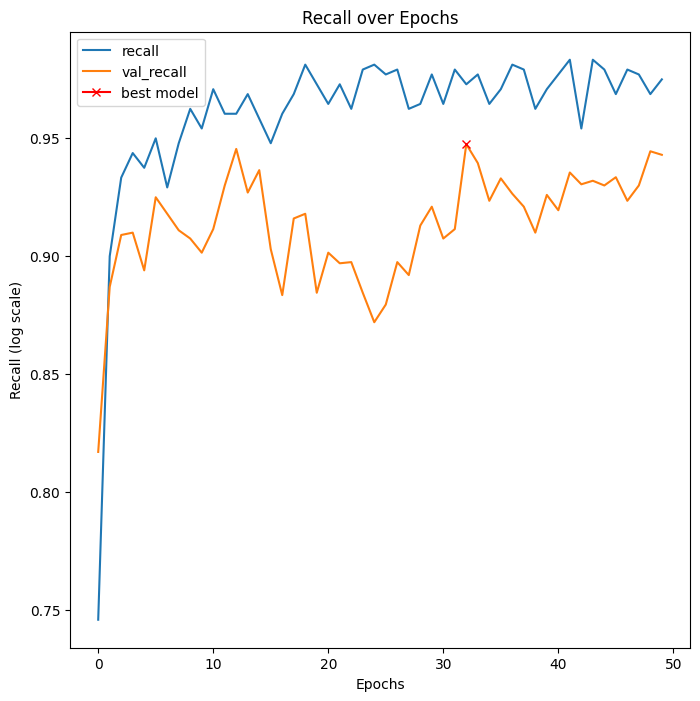

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Recall over Epochs")
plt.plot(history.history["recall"], label="recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.plot(np.argmax(history.history["val_recall"]), np.max(history.history["val_recall"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Recall (log scale)")
plt.legend()
plt.show()

AUC plot

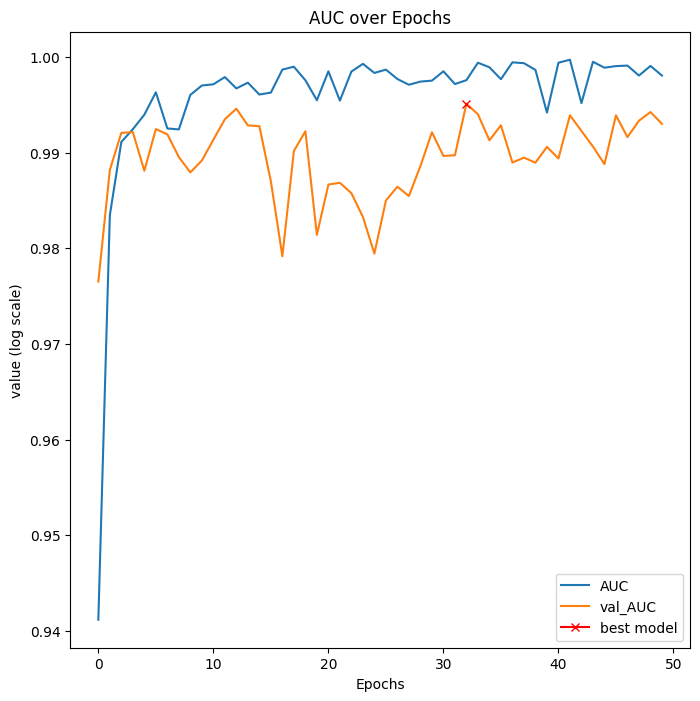

In [20]:
plt.figure(figsize=(8, 8))
plt.title("AUC over Epochs")
plt.plot(history.history["auc"], label="AUC")
plt.plot(history.history["val_auc"], label="val_AUC")
plt.plot(np.argmax(history.history["val_auc"]), np.max(history.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend()
plt.show()

Model prediction

1/1 [==============================] - 0s 46ms/step
[[3.6222718e-05 3.1759578e-04 8.2589680e-04 9.9882025e-01]]
THE UPLOADED IMAGE SEEMS TO BE: Esophagitis


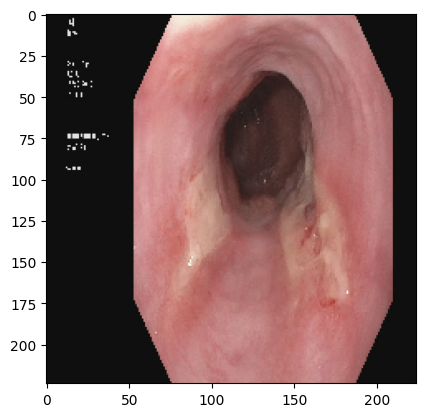

In [ ]:
from keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/kaggledata/Raw_colon/test/3_esophagitis/test_esophagitis_ (17).jpg',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="Normal"
elif a==1:
    op="Ulcerative colitis"
elif a==2:
    op="Polyp"
else:
    op="Esophagitis"

plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))

#Model2 : ResNet50

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 4

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Add custom layers
x = base_model.output
x = GaussianNoise(0.35)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = GaussianNoise(0.35)(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)



model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

model2.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                         

In [22]:
checkpoint = ModelCheckpoint("model2.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

In [23]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=30, 
    epochs = 50,
    validation_data = validation_generator,
    callbacks=callbacks2,
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8229 - precision: 0.8468 - recall: 0.8062 - auc: 0.9663
Epoch 1: val_accuracy improved from -inf to 0.80900, saving model to model2.best.keras
30/30 [==============================] - 66s 2s/step - loss: 0.4725 - accuracy: 0.8229 - precision: 0.8468 - recall: 0.8062 - auc: 0.9663 - val_loss: 0.6751 - val_accuracy: 0.8090 - val_precision: 0.8206 - val_recall: 0.8030 - val_auc: 0.9467 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9333 - precision: 0.9449 - recall: 0.9292 - auc: 0.9899
Epoch 2: val_accuracy did not improve from 0.80900
30/30 [==============================] - 58s 2s/step - loss: 0.2045 - accuracy: 0.9333 - precision: 0.9449 - recall: 0.9292 - auc: 0.9899 - val_loss: 0.9267 - val_accuracy: 0.7705 - val_precision: 0.7796 - val_recall: 0.7605 - val_auc: 0.9279 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - ETA: 0s 

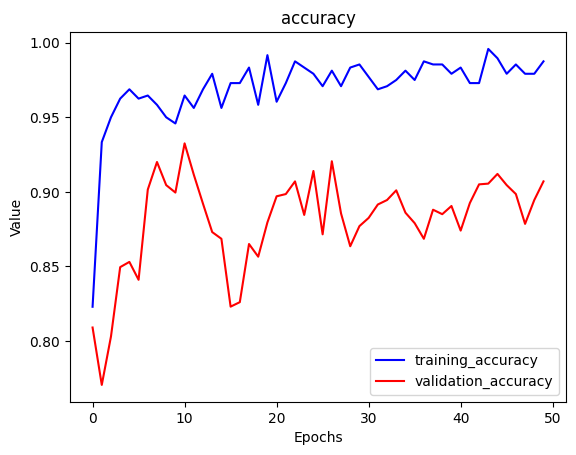

In [31]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
plt.plot(acc, color='blue', label="training_accuracy")
plt.plot(val_acc, color='red', label="validation_accuracy")

plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [62]:
model2.load_weights('model2.best.keras')
model2.evaluate(test_generator)
#بار1: loss: 0.1816 - accuracy: 0.9287 - precision: 0.9309 - recall: 0.9262 - auc: 0.9937
#بار2: loss: 0.1552 - accuracy: 0.9350 - precision: 0.9360 - recall: 0.9325 - auc: 0.9958
#بار3: loss: 0.2079 - accuracy: 0.9200 - precision: 0.9209 - recall: 0.9162 - auc: 0.9910
#acc_avg: 0.9279

50/50 [==============================] - 18s 352ms/step - loss: 0.2079 - accuracy: 0.9200 - precision: 0.9209 - recall: 0.9162 - auc: 0.9910


[0.2078666239976883,
 0.9200000166893005,
 0.9208542704582214,
 0.9162499904632568,
 0.991016149520874]

#Confusion matrix, F1, recall, precision

In [48]:
model2.load_weights('model2.best.keras')
Y_pred = np.argmax(model2.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

<ipython-input-48-67bc560071ce>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model2.predict_generator(test_generator), axis=1)


Confusion Matrix : 
 [[200   0   0   0]
 [  0 162  37   1]
 [  1  11 188   0]
 [  0   2   2 196]]


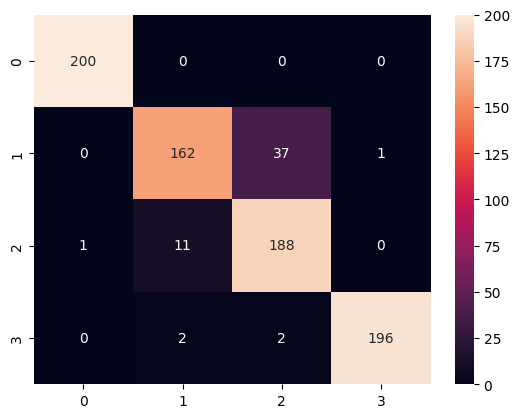

In [49]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

In [51]:
model2.load_weights('model2.best.keras')
X_test= test_generator
y_pred = np.argmax(model2.predict_generator(test_generator), axis=1)
y_test = test_generator.classes

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

<ipython-input-51-92c79d39f421>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.argmax(model2.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9326195522169577
Precision for all classes: 0.9336046527197059
Recall for all classes: 0.9325


#Performance Plots

Learning curve

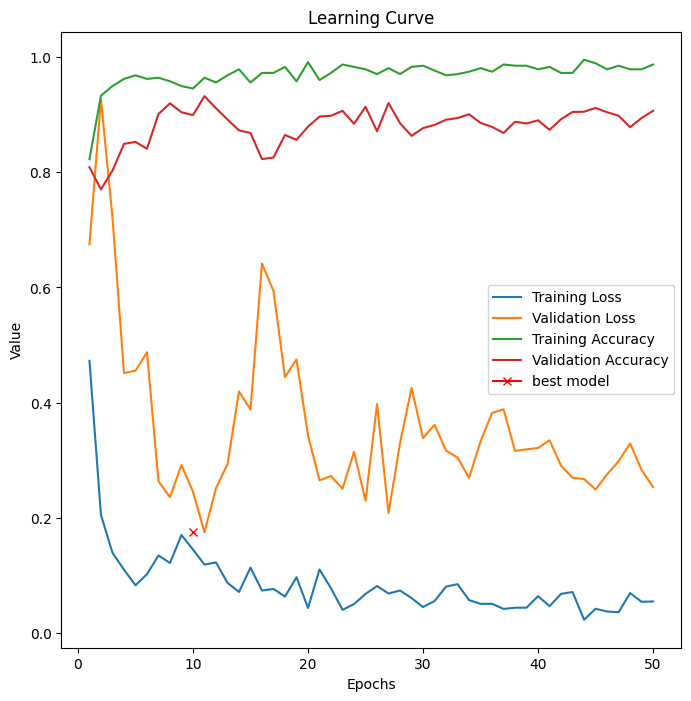

In [32]:
epochs = range(1, len(history2.history['loss']) + 1)
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# learning curve:
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot( np.argmin(history2.history["val_loss"]), np.min(history2.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

Precision plot

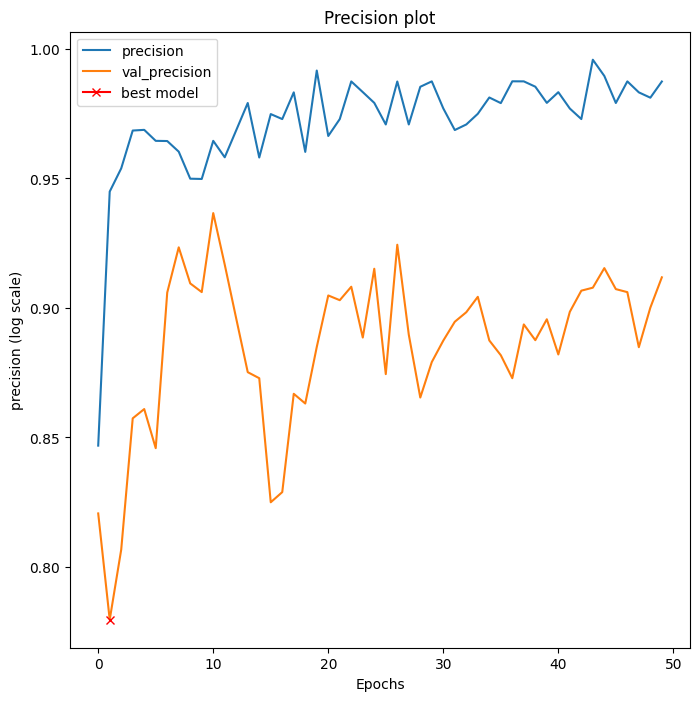

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Precision plot")
plt.plot(history2.history["precision"], label="precision")
plt.plot(history2.history["val_precision"], label="val_precision")
plt.plot( np.argmin(history2.history["val_precision"]), np.min(history2.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("precision (log scale)")
plt.legend();

Recall plot

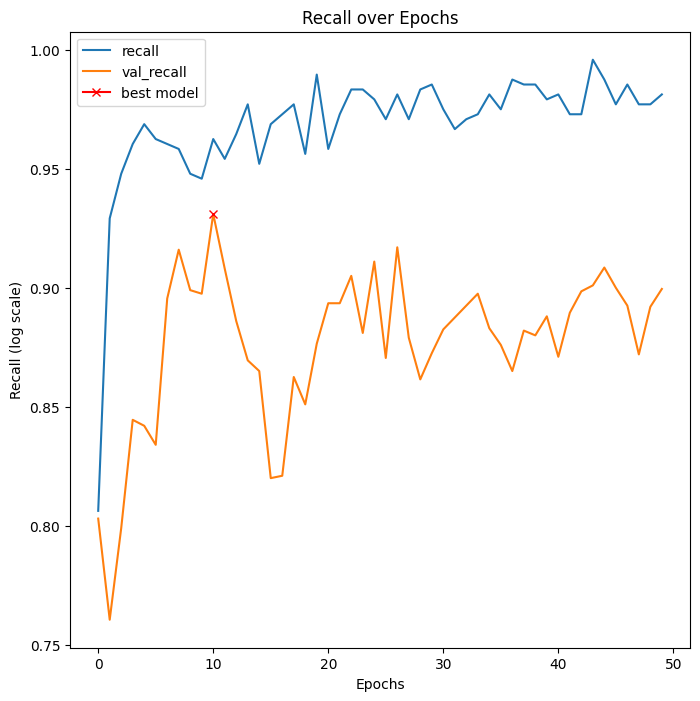

In [34]:
plt.figure(figsize=(8, 8))
plt.title("Recall over Epochs")
plt.plot(history2.history["recall"], label="recall")
plt.plot(history2.history["val_recall"], label="val_recall")
plt.plot(np.argmax(history2.history["val_recall"]), np.max(history2.history["val_recall"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Recall (log scale)")
plt.legend()
plt.show()

AUC plot

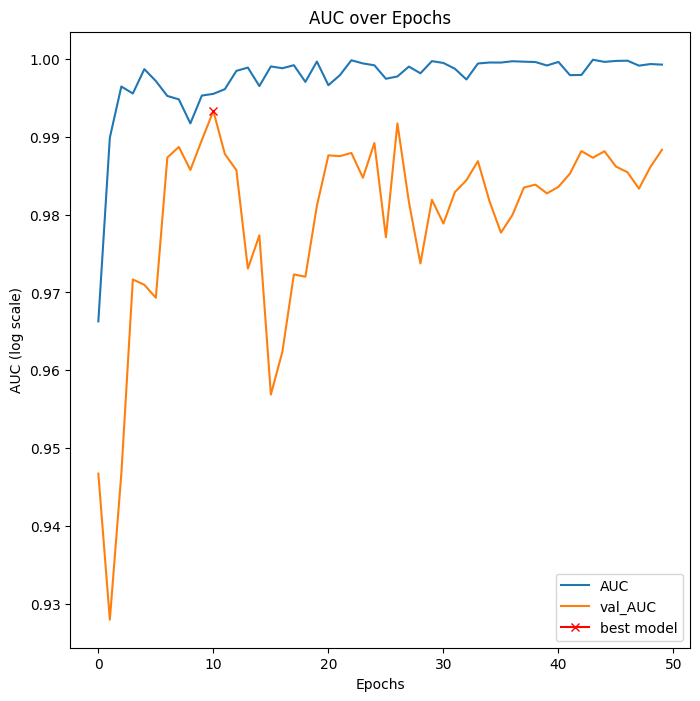

In [35]:
plt.figure(figsize=(8, 8))
plt.title("AUC over Epochs")
plt.plot(history2.history["auc"], label="AUC")
plt.plot(history2.history["val_auc"], label="val_AUC")
plt.plot(np.argmax(history2.history["val_auc"]), np.max(history2.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("AUC (log scale)")
plt.legend()
plt.show()

Model prediction

1/1 [==============================] - 0s 39ms/step
[[1.7528598e-07 9.9474156e-01 3.7637044e-04 4.8819706e-03]]
THE UPLOADED IMAGE SEEMS TO BE: Ulcerative colitis


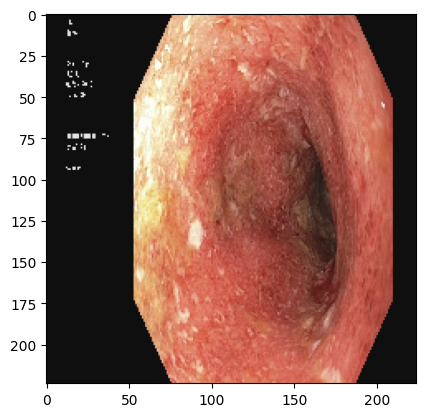

In [ ]:
from keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/kaggledata/Raw_colon/test/1_ulcerative_colitis/test_ulcer_ (189).jpg',target_size=(224,224)) #ulcerative_colitis
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model2.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="Normal"
elif a==1:
    op="Ulcerative colitis"
elif a==2:
    op="Polyp"
else:
    op="Esophagitis"

plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))

#Model3: vgg16

In [36]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GaussianNoise(0.35)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = GaussianNoise(0.35)(x)
x = Dropout(0.2)(x)

predictions = Dense(4, activation='softmax')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

model3.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [37]:
checkpoint = ModelCheckpoint("model3.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

In [38]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch=30, 
    epochs = 50,
    validation_data = validation_generator,
    callbacks=callbacks2,
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.7292 - precision: 0.7605 - recall: 0.6812 - auc: 0.9145
Epoch 1: val_accuracy improved from -inf to 0.69700, saving model to model3.best.keras
30/30 [==============================] - 100s 3s/step - loss: 0.7397 - accuracy: 0.7292 - precision: 0.7605 - recall: 0.6812 - auc: 0.9145 - val_loss: 1.3009 - val_accuracy: 0.6970 - val_precision: 0.7011 - val_recall: 0.6895 - val_auc: 0.8825 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9229 - precision: 0.9319 - recall: 0.9125 - auc: 0.9869
Epoch 2: val_accuracy improved from 0.69700 to 0.77550, saving model to model3.best.keras
30/30 [==============================] - 58s 2s/step - loss: 0.2547 - accuracy: 0.9229 - precision: 0.9319 - recall: 0.9125 - auc: 0.9869 - val_loss: 0.9052 - val_accuracy: 0.7755 - val_precision: 0.7814 - val_recall: 0.7720 - val_auc: 0.9215 - lr: 0.0010
Epoch 3/50
30/30 [==

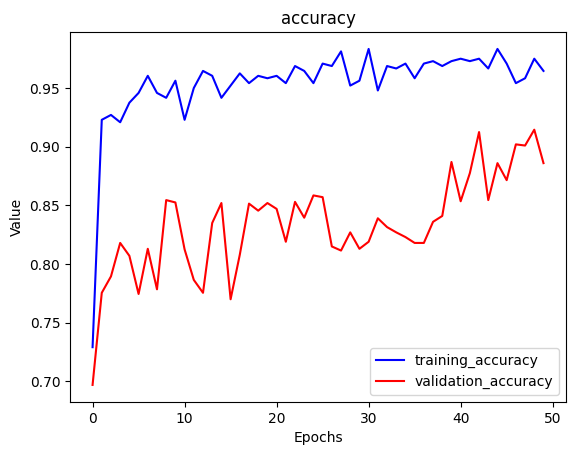

In [44]:
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
plt.plot(acc, color='blue', label="training_accuracy")
plt.plot(val_acc, color='red', label="validation_accuracy")

plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [56]:
model3.load_weights('model3.best.keras')
model3.evaluate(test_generator)
#بار1: loss: 0.1880 - accuracy: 0.9250 - precision: 0.9320 - recall: 0.9250 - auc: 0.9936
#بار2: loss: 0.2021 - accuracy: 0.9262 - precision: 0.9261 - recall: 0.9237 - auc: 0.9907
#بار3: loss: 0.2118 - accuracy: 0.9275 - precision: 0.9283 - recall: 0.9225 - auc: 0.9913
#acc_avg: 0.9262

50/50 [==============================] - 18s 362ms/step - loss: 0.1880 - accuracy: 0.9250 - precision: 0.9320 - recall: 0.9250 - auc: 0.9936


[0.18800722062587738,
 0.925000011920929,
 0.9319899082183838,
 0.925000011920929,
 0.9936437606811523]

#Confusion matrix, F1, recall, precision

In [46]:
model3.load_weights('model3.best.keras')
Y_pred = np.argmax(model3.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

<ipython-input-46-c7173dbdd11e>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model3.predict_generator(test_generator), axis=1)


Confusion Matrix : 
 [[200   0   0   0]
 [  3 159  38   0]
 [  2  26 172   0]
 [  0   2   0 198]]


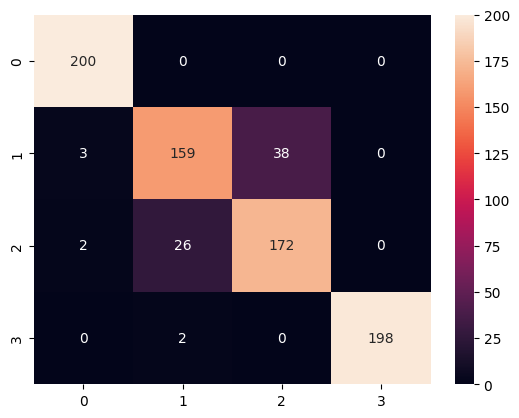

In [47]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

In [50]:
model3.load_weights('model3.best.keras')
X_test= test_generator
y_pred = np.argmax(model3.predict_generator(test_generator), axis=1)
y_test = test_generator.classes

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

<ipython-input-50-2024539bd314>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.argmax(model3.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9223203149825574
Precision for all classes: 0.9231980460349615
Recall for all classes: 0.9225


#Performance Plots

Learning curve

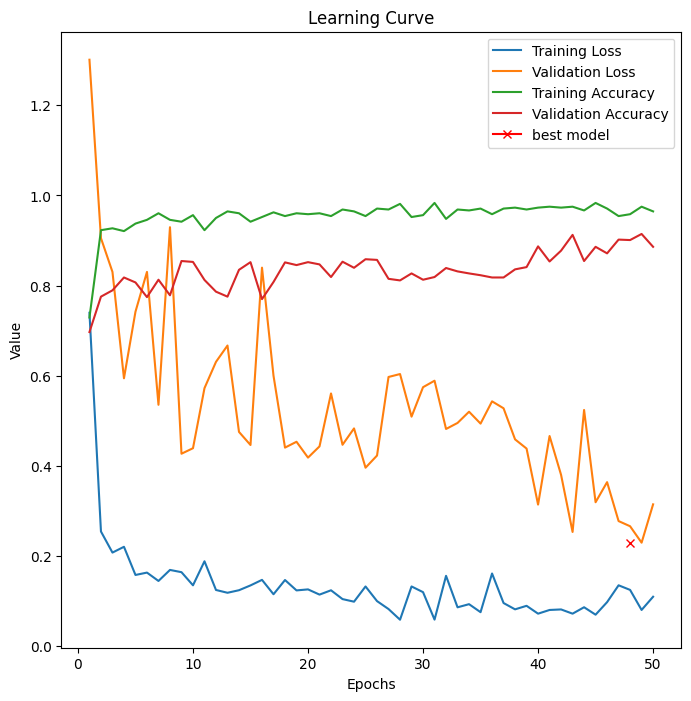

In [45]:
epochs = range(1, len(history3.history['loss']) + 1)
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

# learning curve:
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot( np.argmin(history3.history["val_loss"]), np.min(history3.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

Precision plot

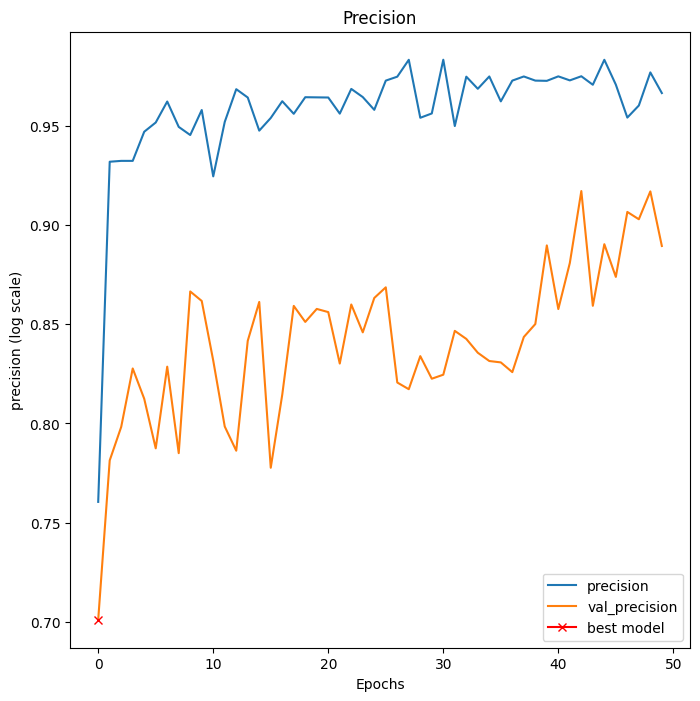

In [41]:
plt.figure(figsize=(8, 8))
plt.title("Precision")
plt.plot(history3.history["precision"], label="precision")
plt.plot(history3.history["val_precision"], label="val_precision")
plt.plot(np.argmin(history3.history["val_precision"]), np.min(history3.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("precision (log scale)")
plt.legend()
plt.show()

Recall plot

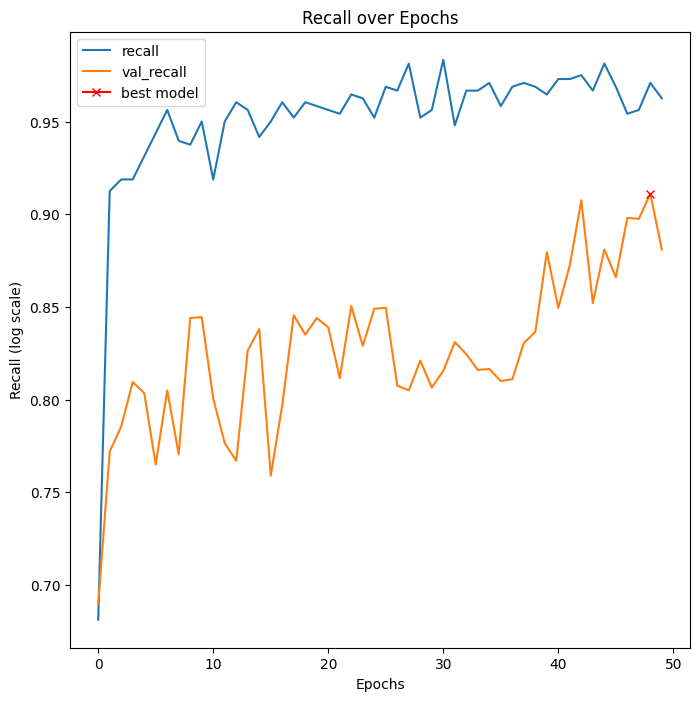

In [42]:
plt.figure(figsize=(8, 8))
plt.title("Recall over Epochs")
plt.plot(history3.history["recall"], label="recall")
plt.plot(history3.history["val_recall"], label="val_recall")
plt.plot(np.argmax(history3.history["val_recall"]), np.max(history3.history["val_recall"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Recall (log scale)")
plt.legend()
plt.show()

AUC

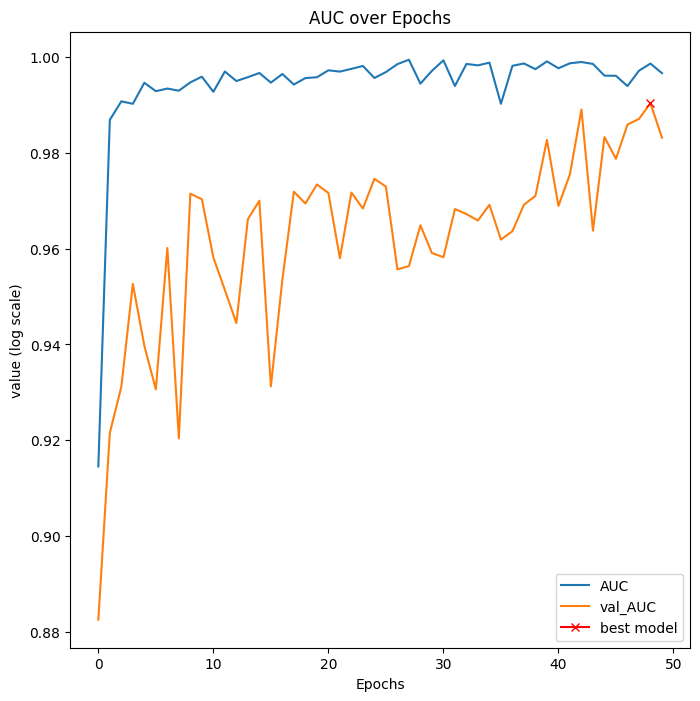

In [43]:
plt.figure(figsize=(8, 8))
plt.title("AUC over Epochs")
plt.plot(history3.history["auc"], label="AUC")
plt.plot(history3.history["val_auc"], label="val_AUC")
plt.plot(np.argmax(history3.history["val_auc"]), np.max(history3.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend()
plt.show()

Model prediction

1/1 [==============================] - 0s 135ms/step
[[0. 0. 1. 0.]]
THE UPLOADED IMAGE SEEMS TO BE: Polyp


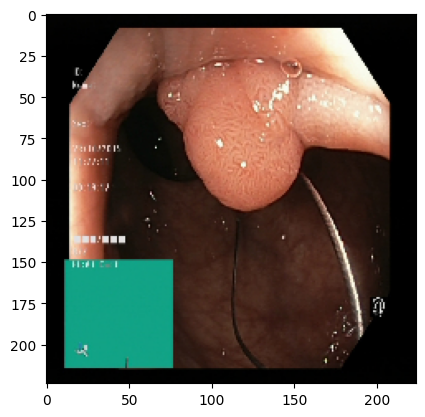

In [ ]:
from keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/kaggledata/Raw_colon/test/2_polyps/test_polyps_ (166).jpg',target_size=(224,224)) #ulcerative_colitis
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model3.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="Normal"
elif a==1:
    op="Ulcerative colitis"
elif a==2:
    op="Polyp"
else:
    op="Esophagitis"

plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))

#so the best model is : EfficientNetB2